### Module 1 : Permutation Importance vs Random Forest Feature Importance (MDI)

This notbook is based on the sklearn permutation importance exercise here:
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

n_estimators are changed to = 3, so that individual tree feature importances can be visualized. This will become important once comparisons to SHAP are made. 

In this example, we will compare the impurity-based feature importance of RandomForestClassifier with the permutation importance on the titanic dataset using permutation_importance. We will show that the impurity-based feature importance can inflate the importance of numerical features.



### Library Import

In [ ]:
print(__doc__)
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

### Data

In [7]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
rng = np.random.RandomState(seed=42)
X['random_cat'] = rng.randint(3, size=X.shape[0])
X['random_num'] = rng.randn(X.shape[0])

categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

X = X[categorical_columns + numerical_columns]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

X_train.head()

,pclass,sex,embarked,random_cat,age,sibsp,parch,fare,random_num
1216,3.0,female,Q,1,NaN,0.0,0.0,7.7333,-0.436386
819,3.0,female,Q,2,NaN,0.0,0.0,7.7500,2.006093
1286,3.0,female,C,2,38.0,0.0,0.0,7.2292,0.521122
1280,3.0,male,S,1,22.0,0.0,0.0,7.8958,-2.135674
761,3.0,male,S,0,16.0,0.0,0.0,9.5000,1.607346


### Model

In [104]:

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(n_estimators=3, random_state=42))
])
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['age', 'sibsp', 'par

In [105]:
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 0.945
RF test accuracy: 0.750


### Impurity Based Feature Importance - Macro

/home/spenser/anaconda3/envs/fool/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


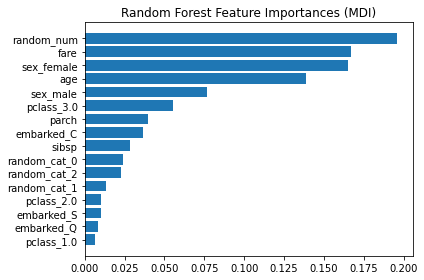

In [114]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()

### Impurity Based Feature Importance - Individual Trees

In [107]:
import pandas as pd 
X_train_transformed = pd.DataFrame(rf.named_steps.preprocess.transform(X_train), columns=feature_names)

In [ ]:
from sklearn.tree import export_graphviz# Export as dot file


export_graphviz(rf.named_steps['classifier'].estimators_[0], 
                out_file='tree.dot', 
                feature_names = X_train_transformed.columns,
                class_names = ['0','1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [109]:

importances = pd.DataFrame(rf.named_steps['classifier'].estimators_[0].feature_importances_.reshape(1,16), columns =  X_train_transformed.columns).T
importances.columns = ['weight']

importances[importances['weight'] >0].sort_values(by='weight', ascending=False)

,weight
random_num,0.207766
fare,0.176601
sex_male,0.154003
age,0.121727
sex_female,0.072310
parch,0.067118
embarked_C,0.054768
sibsp,0.047878
pclass_3.0,0.035397
random_cat_1,0.018596


In [ ]:
from sklearn.tree import export_graphviz# Export as dot file


export_graphviz(rf.named_steps['classifier'].estimators_[1], 
                out_file='tree.dot', 
                feature_names = X_train_transformed.columns,
                class_names = ['0','1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [111]:

importances = pd.DataFrame(rf.named_steps['classifier'].estimators_[1].feature_importances_.reshape(1,16), columns =  X_train_transformed.columns).T
importances.columns = ['weight']

importances[importances['weight'] >0].sort_values(by='weight', ascending=False)

,weight
random_num,0.219797
sex_female,0.203248
fare,0.176340
age,0.131151
pclass_3.0,0.055057
random_cat_0,0.039646
embarked_C,0.030831
sex_male,0.029691
parch,0.028974
random_cat_2,0.028211


In [ ]:
from sklearn.tree import export_graphviz# Export as dot file


export_graphviz(rf.named_steps['classifier'].estimators_[2], 
                out_file='tree.dot', 
                feature_names = X_train_transformed.columns,
                class_names = ['0','1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [113]:

importances = pd.DataFrame(rf.named_steps['classifier'].estimators_[2].feature_importances_.reshape(1,16), columns =  X_train_transformed.columns).T
importances.columns = ['weight']

importances[importances['weight'] >0].sort_values(by='weight', ascending=False)

,weight
sex_female,0.219189
age,0.164058
random_num,0.160646
fare,0.148576
pclass_3.0,0.075415
sex_male,0.046736
random_cat_2,0.031896
random_cat_0,0.025779
sibsp,0.024945
pclass_2.0,0.024468


### Permutation Based Feature Importance
    - Idea is if the feature is truly important, permuting it will have a large effect on the model.
      If the feature is not important, permuting it will have little effect.
        
    - In this example, since the model was overfit on to the continuous random variable (evidence in the bad generalization performance),
      permuting it should not have a large effect on the model. 

### Permutation Feature Importance Calculated on Hold-Out test set 

The estimator is required to be a fitted estimator. X can be the data set used to train the estimator or a hold-out set. The permutation importance of a feature is calculated as follows. First, a baseline metric, defined by scoring, is evaluated on a (potentially different) dataset defined by the X. Next, a feature column from the validation set is permuted and the metric is evaluated again. The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.



| pclass | sex  | embarked  |  random_cat |  age |  sibsp | parch  | fare |random_num |
|---|---|---|---|---|---|---|---|---|
| 3 | female |  Q | 1 | NaN | 0 | 0 | 7.7333 | -0.436386  <b>(1) </b>  |
| 3 | female |  Q | 2 | NaN | 0 | 0 | 7.7500 | 2.006093 <b>(2)</b>  |
| 3 | female |  C | 2 | 38.0| 0	| 0 | 7.2292 |  0.521122 <b><b>(3) </b>  |   
| 3 | female |  S | 1 | 22.0| 0	| 0 | 7.8958 |  -2.135674 <b>(4)</b> |
| 3 | female |  S | 0 | 0.0 | 0 | 0 | 9.5000 |  1.607346 <b>(5)</b> |

Randomly permute random_num column : 

| pclass | sex  | embarked  |  random_cat |  age |  sibsp | parch  | fare |random_num |
|---|---|---|---|---|---|---|---|---|
| 3 | female |  Q | 1 | NaN | 0 | 0 | 7.7333 | -2.135674 <b>(4)</b> |
| 3 | female |  Q | 2 | NaN | 0 | 0 | 7.7500 | 2.006093 <b>(2)</b>  |
| 3 | female |  C | 2 | 38.0| 0	| 0 | 7.2292 | 0.521122 <b>(3)</b>|   
| 3 | female |  S | 1 | 22.0| 0	| 0 | 7.8958 | -0.436386 <b>(1</b>)|
| 3 | female |  S | 0 | 0.0 | 0 | 0 | 9.5000 |  1.607346 <b>(5) </b>|
    
    
This processess continues randomly for all columns, and the <b> change in predicted probability </b> of the underlying model is measured. 

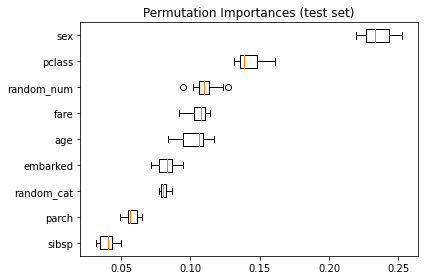

In [115]:
result = permutation_importance(rf, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()


fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

### Permutation Feature Importance Calculated on Hold-Out test set 

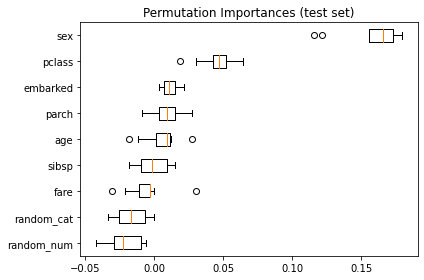

In [116]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

### Conclusion - note that for the hold-out test set, the random number category is much less important.

The scikit-learn manual takes this as sufficient evidence that the model is overfit to random_num; although this is reduced in the permutation importance for train, it is not entirely elimimated.

Impurtity bsaed feature importance from random forest is known to overfit based on features with high <b> cardinality </b> (many unique values available to curve fit)

Permutation importance allows feature attribution on the test set to enable this to be detected, it permutes the features (taking it's regular row-wise distribution) and measures change in predicted probability. 